## Data

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torchvision.transforms import ToTensor

training_data = torchvision.datasets.MNIST(root='./data', transform=ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=ToTensor(), download=True)

In [3]:
from torch.utils.data import DataLoader

training_dataloader = DataLoader(training_data, batch_size=len(training_data), shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [4]:
X_training, Y_training = next(iter(training_dataloader))
X_training.shape, Y_training.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [5]:
X_test, Y_test = next(iter(test_dataloader))
X_test.shape, Y_test.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [6]:
X_training = X_training.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_training.shape, Y_training.shape, X_test.shape, Y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [7]:
X_training_subset = torch.cat([X_training[Y_training==0], X_training[Y_training==1]])
Y_training_subset = torch.cat([Y_training[Y_training==0], Y_training[Y_training==1]])
X_test_subset = torch.cat([X_test[Y_test==0], X_test[Y_test==1]])
Y_test_subset = torch.cat([Y_test[Y_test==0], Y_test[Y_test==1]])
X_training_subset.shape, Y_training_subset.shape, X_test_subset.shape, Y_test_subset.shape

(torch.Size([12665, 784]),
 torch.Size([12665]),
 torch.Size([2115, 784]),
 torch.Size([2115]))

In [48]:
from sklearn.model_selection import train_test_split

X_train_large, X_val, Y_train_large, Y_val = train_test_split(X_training, Y_training, test_size=1000)
X_train, X_dummy, Y_train, Y_dummy = train_test_split(X_train_large, Y_train_large, train_size=1000)

# X_train, X_val, Y_train, Y_val = train_test_split(X_training_subset, Y_training_subset, test_size=0.2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([1000, 784]),
 torch.Size([1000, 784]),
 torch.Size([1000]),
 torch.Size([1000]))

## NN

In [9]:
device = 'cpu'

In [49]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train.unsqueeze(1).type(torch.float32), batch_size=32, shuffle=True), make_dataloader(X_val, Y_val.unsqueeze(1).type(torch.float32), batch_size=32)

In [54]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=784, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=1),
        )
    
    def forward(self, x):
        return self.layers(x)


In [55]:
from torchinfo import summary

summary(
    model=SimpleNN(),
    input_size=(32, 784),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
SimpleNN                                 [32, 784]            [32, 1]              --                   True
├─Sequential: 1-1                        [32, 784]            [32, 1]              --                   True
│    └─Linear: 2-1                       [32, 784]            [32, 100]            78,500               True
│    └─ReLU: 2-2                         [32, 100]            [32, 100]            --                   --
│    └─Linear: 2-3                       [32, 100]            [32, 100]            10,100               True
│    └─ReLU: 2-4                         [32, 100]            [32, 100]            --                   --
│    └─Linear: 2-5                       [32, 100]            [32, 1]              101                  True
Total params: 88,701
Trainable params: 88,701
Non-trainable params: 0
Total mult-adds (M): 2.84
Input size (MB): 0.10
Forward/b

In [56]:
model_nn = SimpleNN().to(device)

In [57]:
from scripts.metrics import NegMeanSquaredError

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_nn.parameters())
metric = NegMeanSquaredError()

In [58]:
from scripts.train import train_model

history = train_model(
    model=model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    device=device
)

Training model for 500 epochs. Early stopping not enabled.
Epoch: 1 => Train loss: 14.515871, Train score: -14.515871, Val loss: 7.364921, Val score: -7.364921
Epoch: 2 => Train loss: 5.570661, Train score: -5.570661, Val loss: 4.844414, Val score: -4.844414
Epoch: 3 => Train loss: 4.407667, Train score: -4.407667, Val loss: 4.238711, Val score: -4.238711
Epoch: 4 => Train loss: 3.703383, Train score: -3.703383, Val loss: 3.898758, Val score: -3.898758
Epoch: 5 => Train loss: 3.295232, Train score: -3.295232, Val loss: 3.637668, Val score: -3.637668
Epoch: 6 => Train loss: 2.965289, Train score: -2.965289, Val loss: 3.557545, Val score: -3.557545
Epoch: 7 => Train loss: 2.563121, Train score: -2.563121, Val loss: 3.217115, Val score: -3.217115
Epoch: 8 => Train loss: 2.242999, Train score: -2.242999, Val loss: 3.088239, Val score: -3.088239
Epoch: 9 => Train loss: 2.047627, Train score: -2.047627, Val loss: 2.944558, Val score: -2.944558
Epoch: 10 => Train loss: 1.736168, Train score: 

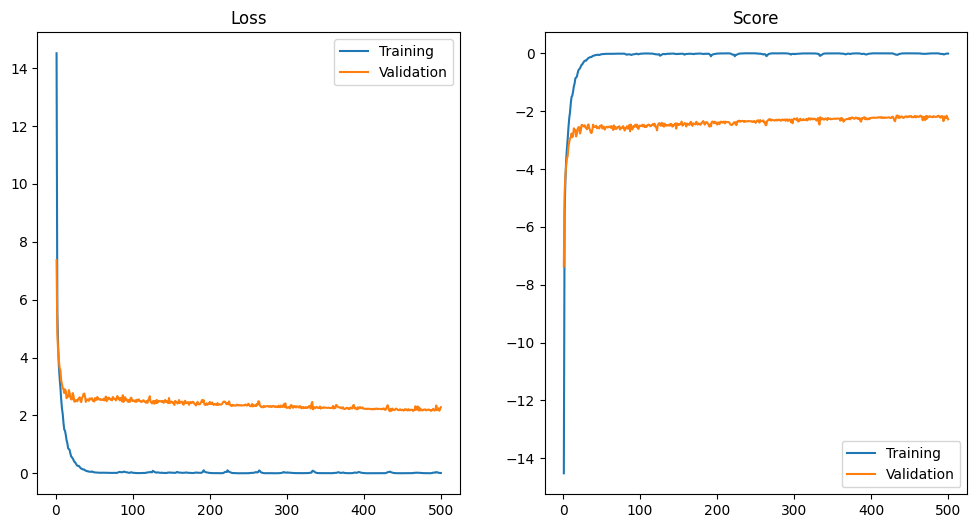

In [59]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [60]:
from scripts.test import predict

preds_train, preds_val = predict(model_nn, X_train, device), predict(model_nn, X_val, device)
score_train, score_val = metric(preds_train, Y_train.unsqueeze(1)), metric(preds_val, Y_val.unsqueeze(1))
score_train, score_val

(tensor(-0.0210), tensor(-2.2694))

In [62]:
preds_nn = predict(model_nn, X_test_subset, device)
score_test = metric(preds_nn, Y_test_subset.unsqueeze(1))
score_test

tensor(-0.8078)

## NTK

In [63]:
def get_grads(u, model):
    return torch.cat([torch.reshape(grads, (-1,)) for grads in list(torch.autograd.grad(model(u), model.parameters()))]).reshape(1, -1)

def compute_ntk(U, V, model):
    phi_u = torch.cat([get_grads(u, model) for u in U])
    phi_v = torch.cat([get_grads(v, model) for v in V])
    return torch.matmul(phi_u, phi_v.T)

In [64]:
class NTK():
    def __init__(self, model) -> None:
        self.model = model
    
    def get_ntk(self, U, V):
        return compute_ntk(U, V, self.model)

In [65]:
u = torch.rand(1, 784)
get_grads(u, model_nn), get_grads(u, model_nn).shape

(tensor([[0., 0., 0.,  ..., 0., 0., 1.]]), torch.Size([1, 88701]))

## SVM

In [22]:
from sklearn.metrics import accuracy_score, mean_squared_error

In [23]:
from sklearn.svm import SVC, SVR

### T = 0

In [66]:
ntk_init = NTK(SimpleNN().to(device))

In [67]:
model_km_init = SVR(kernel=ntk_init.get_ntk)

In [68]:
model_km_init.fit(X_train, Y_train)

SVR(kernel=<bound method NTK.get_ntk of <__main__.NTK object at 0x7f3c7cb71e40>>)

In [69]:
preds_train, preds_val = model_km_init.predict(X_train), model_km_init.predict(X_val)
score_train, score_val = mean_squared_error(Y_train, preds_train), mean_squared_error(Y_val, preds_val)
score_train, score_val

(0.9430033185936384, 2.3479289298748514)

In [71]:
preds_km_init = model_km_init.predict(X_test_subset)
score_test = mean_squared_error(Y_test_subset, preds_km_init)
score_test

2.148766686105103

### T = inf

In [72]:
ntk_inf = NTK(model_nn)

In [73]:
model_km_inf = SVR(kernel=ntk_inf.get_ntk)

In [74]:
model_km_inf.fit(X_train, Y_train)

SVR(kernel=<bound method NTK.get_ntk of <__main__.NTK object at 0x7f3bfe624130>>)

In [75]:
preds_train, preds_val = model_km_inf.predict(X_train), model_km_inf.predict(X_val)
score_train, score_val = mean_squared_error(Y_train, preds_train), mean_squared_error(Y_val, preds_val)
score_train, score_val

(0.005554487574558696, 2.3031331167521856)

In [76]:
preds_km_inf = model_km_inf.predict(X_test_subset)
score_test = mean_squared_error(Y_test_subset, preds_km_inf)
score_test

0.9140466809128425

## Plot

In [77]:
preds_nn.shape, preds_km_init.shape, preds_km_inf.shape

(torch.Size([2115, 1]), (2115,), (2115,))

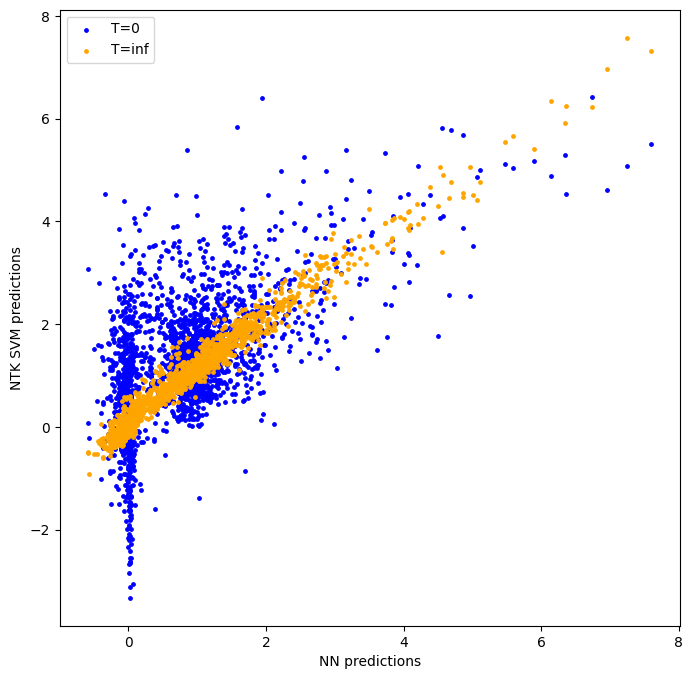

In [80]:
plt.figure(figsize=(8, 8))

plt.scatter(preds_nn.squeeze(), preds_km_init, c='blue', label='T=0', s=6)
plt.scatter(preds_nn.squeeze(), preds_km_inf, c='orange', label='T=inf', s=6)
plt.xlabel('NN predictions')
plt.ylabel('NTK SVM predictions')
plt.legend()

In [79]:
from scipy.stats import pearsonr

corr_init, corr_inf = pearsonr(preds_nn.squeeze(), preds_km_init), pearsonr(preds_nn.squeeze(), preds_km_inf)
corr_init, corr_inf

(PearsonRResult(statistic=0.5833526493855815, pvalue=4.096877216669984e-193),
 PearsonRResult(statistic=0.9822623283311467, pvalue=0.0))